# Brief analysis of local Foursquare recommendation and US Presidential Elections results in Florida


# 1. Introduction

The US presidential election is one of the most important events in the country. They happen every four years, the last one in 2016, where the main candidates were Donald Trump and Hillary Clinton. Results are obtained after deciding which candidate has won in each of the states, which are divided into counties. <br>
Many specialists try to forecast what the trend is in each of the states, in order to use that information and convey an adapted message to each of them in the electoral campaign. It is not an easy task, many parametres and factors should be keeping in mind to develop a correct model. <br>
The next image shows the final results int he past elections. If you want to interact with the map, go to https://www.nytimes.com/elections/2016/results/president, the web page of the New York Times.

<img src="ElectionsMap.png" alt="800" width="800"/>

**The purpose of this project** consists of analyzing the trendings that Foursquare stored some days before the elections day. Joining them with the least number of population factors such as total number of inhabitants, average income, etc., an attempt will be made to classify Florida's councies into two different types. If the final clusters looks like the map results which is above, we could cloncude that analyzing the trendings can be used to understand and predict the population behaviour. <br>

**Why Florida?** Okey, there are 50 States, but many have a lot of differences with the others. Trying to analyze all of them is something that is out of scoped of this project. Florida has been the chosen because some reasonable reasons: it's large enough, there are many councies and cities, and the results of the elections show that both, Trump and Clinton, could won in this State.

**Some things to keep in mind:**
1. I will cluster the councies in two groups trying to simulate the principal options, which are Donald Trump and Hillary Clinton.
2. Because of the restrictions of the free account in Foursquare, only Florida will be analyzed.
3. I don't have any expectations about the result, I won't use some parameters that could be important. This is just for fun.


In [1]:
import pandas as pd
import numpy as np
import requests
import folium
import os

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# 2. Datasets

## 2.1 Presidential Elections 2016

This dataset contains the results of the past elections. It stores a lot of information which can be used to cluster the population and forecasting, like population description, population incomes, medium age, etc. Each row in this .csv file represents the result that was obtained by both candidates in all of the counties of USA. <br>
In this project only some fields are going to be considered, a complete analisys is out of the scope of this course. We do this just for fun. <br>

**url**: https://www.kaggle.com/prashant111/us-presidential-election-data

In [2]:
# load the dataset
elections_16 = pd.read_csv('votes.csv')

# choose the columns that are going to be considered in the project.
columns = ['county_name', 'state_abbr', 'population2014', 'age65plus', 'income', 'poverty',  \
           'total_votes_2016', 'clinton', 'trump']

# rename the columns
elections_16 = elections_16[columns]
elections_16.columns = ['county', 'state', 'population', '65plus', 'income', 'poverty', 'total_votes', 'clinton', 'trump']

# see some data
elections_16.head()

,county,state,population,65plus,income,poverty,total_votes,clinton,trump
0,Autauga County,AL,55395,13.8,24571,12.1,24661,0.239569,0.734358
1,Baldwin County,AL,200111,18.7,26766,13.9,94090,0.195653,0.773515
2,Barbour County,AL,26887,16.5,16829,26.7,10390,0.466603,0.522714
3,Bibb County,AL,22506,14.8,17427,18.1,8748,0.214220,0.769662
4,Blount County,AL,57719,17.0,20730,15.8,25384,0.084699,0.898519


## 2.2 Councies locations

The second dataset contains the coordinates of the cities of every county. As this notebook demonstrates in the next cells, this dataset has more States than the other, so filter, clean and join both is needed before starting making any analisys. <br>

**url**: https://docs.gaslamp.media/download-zip-code-latitude-longitude-city-state-county-csv/

In [3]:
# load the dataset
locations = pd.read_csv('zip_codes_states.csv')
locations = locations.dropna().reset_index(drop=True)

# verifying and count duplicates geographic points
unique_coor = set(zip(locations['latitude'], locations['longitude']))
print(len(unique_coor), 'diferent coordinates', len(locations), 'total coordinates')

# see some data
locations.head()

33455 diferent coordinates 42049 total coordinates


,zip_code,latitude,longitude,city,state,county
0,501,40.922326,-72.637078,Holtsville,NY,Suffolk
1,544,40.922326,-72.637078,Holtsville,NY,Suffolk
2,601,18.165273,-66.722583,Adjuntas,PR,Adjuntas
3,602,18.393103,-67.180953,Aguada,PR,Aguada
4,603,18.455913,-67.145780,Aguadilla,PR,Aguadilla


# 3. FLORIDA

## 3.1 Votes in Florida

**geojson:** https://raw.githubusercontent.com/MiamiHerald/florida-topojson-sources/master/florida-counties.json

In [4]:
florida_votes = elections_16[elections_16['state'] == 'FL'].reset_index(drop=True)

florida_votes['winner'] = pd.Series([0 if i[0]>i[1] \
                                     else 1 for i in zip(florida_votes['trump'], florida_votes['clinton'])])
florida_votes['county'] = florida_votes['county'].replace(to_replace = r' County', value = '', regex=True)

print(florida_votes.shape)
florida_votes.head()

(67, 10)


,county,state,population,65plus,income,poverty,total_votes,clinton,trump,winner
0,Alachua,FL,256380,12.5,24857,24.9,127827,0.589625,0.364430,1
1,Baker,FL,27093,12.9,19852,17.3,12634,0.167168,0.814785,0
2,Bay,FL,178985,16.1,24498,14.7,87151,0.248867,0.711524,0
3,Bradford,FL,26702,17.6,17749,18.2,12098,0.241693,0.736733,0
4,Brevard,FL,556885,22.6,27009,13.5,314337,0.380245,0.577788,0


## 3.2 Locations in Florida

In [5]:
florida_locations = locations[locations['state'] == 'FL'].reset_index(drop=True)
florida_locations.head()

,zip_code,latitude,longitude,city,state,county
0,32004,29.937673,-81.420603,Ponte Vedra Beach,FL,Saint Johns
1,32007,29.799631,-81.627324,Bostwick,FL,Putnam
2,32008,30.101927,-82.908004,Branford,FL,Suwannee
3,32009,30.521109,-81.906051,Bryceville,FL,Nassau
4,32011,30.556322,-81.837594,Callahan,FL,Nassau


**Confirm that all the counties in votes register appear in the location dataset. If not, it would have to search this locations in others datasets.**

In [6]:
votes_counties = set(florida_votes['county'].unique())
locations_counties = set(florida_locations['county'].unique())
len(votes_counties and locations_counties), len(votes_counties), len(florida_locations)

(67, 67, 1447)

## 3.3 One location per city

**Because the limits of the free account in Foursquare, only one point per city is going to be searched. In the cells bellow that is explained with more details. The point that is chosen in the cities is the closest to the mean of all of the points in the city. In this way, we can suppose that this is the closest point to the center of the city (it doesn't have to be truth, but in most of the cases yes)**

In [7]:
final_coordinates = list()

for count in florida_locations['county'].unique():
    df_county = florida_locations[florida_locations['county']==count]
    for cit in df_county['city'].unique():
        df_city = df_county[df_county['city'] == cit]
        mean_lat, mean_long = df_city['latitude'].mean(), df_city['longitude'].mean()
        df_city['rms'] = (df_city['latitude'] - mean_lat)**2 + (df_city['longitude'] - mean_long)**2
        for index, i in enumerate(df_city['rms']):
            if i == df_city['rms'].min():
                final_coordinates.append(df_city.index[index])
                break

florida_locations = florida_locations.loc[final_coordinates, :].reset_index(drop=True)
# print the number of coordinates after filtering, verify that there are not duplicates and the number of unique
# cities in the hole dataset. All of the numbers should be 517
len(final_coordinates), len(set(final_coordinates)), len(florida_locations)

/home/alex/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(525, 525, 525)

## 3.4 Exploraty Data Analysis

### 3.4.1 Correlation between parameters

In [8]:
elections_16[['population','65plus', 'income','poverty']].corr()

,population,65plus,income,poverty
population,1.000000,-0.222524,0.260816,-0.063957
65plus,-0.222524,1.000000,-0.040189,-0.101606
income,0.260816,-0.040189,1.000000,-0.726398
poverty,-0.063957,-0.101606,-0.726398,1.000000


### 3.4.2 Poverty vs Income

Text(0, 0.5, 'Annual Income')

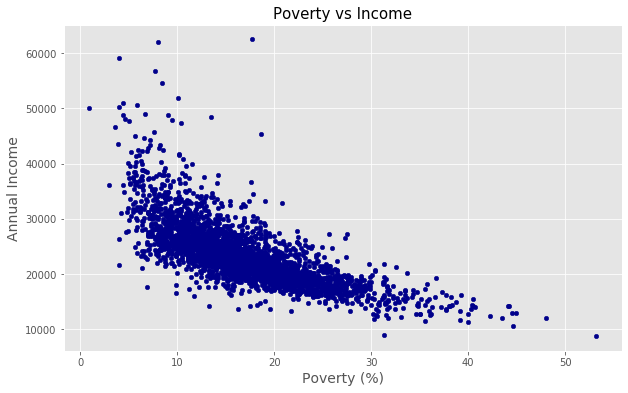

In [9]:
elections_16.plot(kind='scatter', x='poverty', y='income', figsize=(10, 6), color='darkblue')

plt.title('Poverty vs Income', fontsize=15)
plt.xlabel('Poverty (%)', fontsize=14)
plt.ylabel('Annual Income', fontsize=14)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

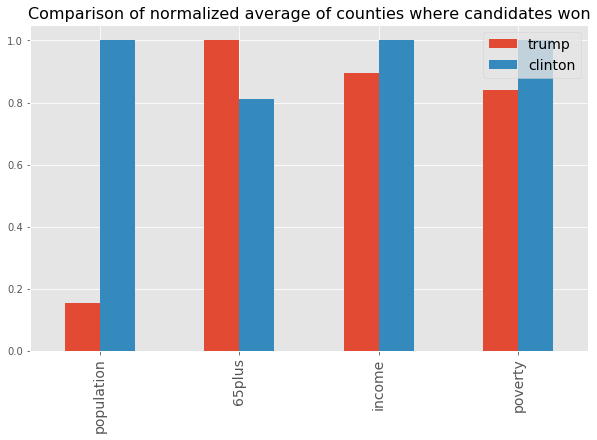

In [10]:
clinton = elections_16[elections_16['clinton'] > elections_16['trump']].drop(columns = ['clinton', 'trump', 'total_votes'])
clinton_desc = clinton.describe()

trump = elections_16[elections_16['clinton'] < elections_16['trump']].drop(columns = ['clinton', 'trump', 'total_votes'])
trump_desc = trump.describe()

comparison = pd.DataFrame(index = trump_desc.columns)
comparison['trump'] = trump_desc.iloc[1,:]
comparison['clinton'] = clinton_desc.iloc[1,:]

for i in range(len(comparison)):
    comparison.iloc[i,:] /= comparison.iloc[i,:].max()


bars = comparison.plot.bar(figsize=(10,6))

# Setting parameters
plt.title('Comparison of normalized average of counties where candidates won', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)


### 3.4.3 Correlation between parameters in Florida

In [11]:
florida_votes[['population','65plus', 'income','poverty']].corr()

,population,65plus,income,poverty
population,1.000000,-0.110823,0.372807,-0.244812
65plus,-0.110823,1.000000,0.305341,-0.310828
income,0.372807,0.305341,1.000000,-0.751438
poverty,-0.244812,-0.310828,-0.751438,1.000000


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

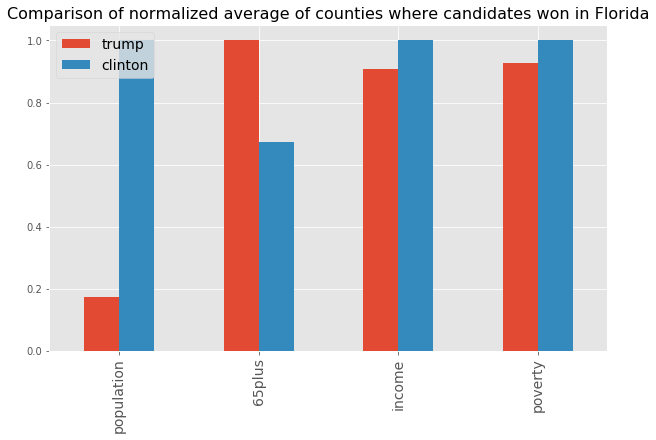

In [12]:
clinton = florida_votes[florida_votes['clinton'] > florida_votes['trump']].drop(columns = ['clinton', 'trump', 'total_votes'])
clinton_desc = clinton.describe()

trump = florida_votes[florida_votes['clinton'] < florida_votes['trump']].drop(columns = ['clinton', 'trump', 'total_votes', 'winner'])
trump_desc = trump.describe()

comparison = pd.DataFrame(index = trump_desc.columns)
comparison['trump'] = trump_desc.iloc[1,:]
comparison['clinton'] = clinton_desc.iloc[1,:]

for i in range(len(comparison)):
    comparison.iloc[i,:] /= comparison.iloc[i,:].max()


bars = comparison.plot.bar(figsize=(10,6))

# Setting parameters
plt.title('Comparison of normalized average of counties where candidates won in Florida', fontsize=16)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)


# 4. FOURSQUARE

## 4.1 Credentials, version and limit of request

In [8]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20161008' # day of elections

## 4.2 Foursquare search query
**url:** https://developer.foursquare.com/docs/api-reference/venues/search/

### Search for recommendations near a location
> `https://api.foursquare.com/v2/venues/trending`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&
ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&radius=`**RADIUS**`&limit=`**LIMIT**

In [9]:
def explore(lat, long, version=VERSION, client_id=CLIENT_ID, client_secret=CLIENT_SECRET, limit=10, radius=2000):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={} \
    &ll={},{}&v={}&limit={}&radius={}'.format(client_id, client_secret,lat, long, \
    version, limit, radius)

## 4.3 List of categories in Foursquare

In [10]:
def getCategories():
    url = 'https://api.foursquare.com/v2/venues/categories?client_id={} \
    &client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION) # define URL

    # send GET request
    results = requests.get(url).json()

    result_categories = results['response']['categories']

    categories = {}
    for element in result_categories:
        name = element['name']
        sub_categories = [(cat['name'], cat['id']) for cat in element['categories']]
        categories[name] = sub_categories
        
    return categories

def parent_categorie(subcategorie, list_categories):
    for cat in list_categories.keys():
        for subcat in list_categories[cat]:
            if subcat[0] == subcategorie:
                return cat
        

categories = getCategories()

## 4.4 Create the results template

In [11]:
if 'explore_florida.csv' not in os.listdir():
    cols = categories.keys()
    index = florida_votes['county'].unique()

    explore_florida = pd.DataFrame(index=index, columns=cols)
    explore_florida.loc[:,:] = 0

    explore_florida.to_csv('explore_florida.csv', header=True, index=True)
else:
    explore_florida = pd.read_csv('explore_florida.csv', index_col=0)
    
print(explore_florida.shape)
explore_florida.head()

(67, 10)


,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Alachua,0,0,0,0,0,0,0,0,0,0
Baker,0,0,0,0,0,0,0,0,0,0
Bay,0,0,0,0,0,0,0,0,0,0
Bradford,0,0,0,0,0,0,0,0,0,0
Brevard,0,0,0,0,0,0,0,0,0,0


## 4.5 Remember locations

**There are 67 registers in florida_votes dataset, asociated with all of the counties in florida**

In [12]:
print(florida_votes.shape)
florida_votes.head()

(67, 10)


,county,state,population,65plus,income,poverty,total_votes,clinton,trump,winner
0,Alachua,FL,256380,12.5,24857,24.9,127827,0.589625,0.364430,1
1,Baker,FL,27093,12.9,19852,17.3,12634,0.167168,0.814785,0
2,Bay,FL,178985,16.1,24498,14.7,87151,0.248867,0.711524,0
3,Bradford,FL,26702,17.6,17749,18.2,12098,0.241693,0.736733,0
4,Brevard,FL,556885,22.6,27009,13.5,314337,0.380245,0.577788,0


**... and there are 525 locations, which represents 'the most centric' points of all the cities in counties**

In [13]:
print(florida_locations.shape)
florida_locations.head()

(525, 6)


,zip_code,latitude,longitude,city,state,county
0,32082,30.102212,-81.382302,Ponte Vedra Beach,FL,Saint Johns
1,32033,29.813208,-81.468724,Elkton,FL,Saint Johns
2,32085,29.937673,-81.420603,Saint Augustine,FL,Saint Johns
3,32145,29.688750,-81.406081,Hastings,FL,Saint Johns
4,32259,29.877289,-81.561245,Jacksonville,FL,Saint Johns


## 4.6 Last changes before collecting

**There are some rows in the datasets that refer to the same county but the name is different.**

In [14]:
print(set(florida_locations['county']) - set(florida_votes['county']))
print(set(florida_votes['county']) - set(florida_locations['county']))

{'Saint Johns', 'Saint Lucie', 'De Soto'}
{'DeSoto', 'St. Lucie', 'St. Johns'}


**have to change the names in the locations because the output dataframe was generated with the counties of the votes dataset**

In [15]:
florida_locations['county'] = florida_locations['county'].replace('De Soto', 'DeSoto')
florida_locations['county'] = florida_locations['county'].replace('Saint Johns', 'St. Johns')
florida_locations['county'] = florida_locations['county'].replace('Saint Lucie', 'St. Lucie')

print(set(florida_locations['county']) - set(florida_votes['county']))
print(set(florida_locations['county']) - set(explore_florida.index))

set()
set()


In [16]:
print(set(florida_locations['county']) - set(explore_florida.index))

set()


## 4.7 Collect data from Foursquare
1. Read a location(city) in florida_locations.
2. Set the county of this location.
3. Query Foursquare about trendings in this location.
4. Collect the results and add the categories of the trendings into trendings_florida.

**IMPORTANT: 'If you are currently over limits, our API will return a 403 error, and the response object returned by our API will be empty. We will also include a X-RateLimit-Reset header in the response, which is a timestamp that corresponds to when your rate limits will reset' (Foursquare)**

In [17]:
import urllib
import sys


for locat_index, locat in florida_locations[23::].iterrows():
    print('new city!', locat_index)
    lat = locat['latitude']
    long = locat['longitude']
    count = locat['county']
    
    url = explore(lat, long)
    try:
        response = requests.get(url).json()
        if response['response']:
            items = response['response']['groups'][0]['items']
            if items:
                for it in items:
                    cats = it['venue']['categories']
                    for cat in cats:
                        if cat['primary']:
                            cat_name = cat['name']
                            parent = parent_categorie(cat_name, categories)
                            if parent:
                                explore_florida.loc[count, parent] += 1
        else:
            print('Index:', locat_index)
            print('City:', locat['city'])
            print('Coordinates:', (lat, long))
            explore_florida.to_csv('output.csv', header=True, index=True)
            sys.exit(0)

    except urllib.error.HTTPError as e:
        if e.code == 403:
            print('Index:', locat_index)
            print('City:', locat['city'])
            print('Coordinates:', (lat, long))
            explore_florida.to_csv('output.csv', header=True, index=True)
            sys.exit(1)
                
explore_florida.to_csv('output.csv', header=True, index=True)

new city! 23
new city! 24
new city! 25
new city! 26
new city! 27
new city! 28
new city! 29
new city! 30
new city! 31
new city! 32
new city! 33
new city! 34
new city! 35
new city! 36
new city! 37
new city! 38
new city! 39
new city! 40
new city! 41
new city! 42
new city! 43
new city! 44
new city! 45
new city! 46
new city! 47
new city! 48
new city! 49
new city! 50
new city! 51
new city! 52
new city! 53
new city! 54
new city! 55
new city! 56
new city! 57
new city! 58
new city! 59
new city! 60
new city! 61
new city! 62
new city! 63
new city! 64
new city! 65
new city! 66
new city! 67
new city! 68
new city! 69
new city! 70
new city! 71
new city! 72
new city! 73
new city! 74
new city! 75
new city! 76
new city! 77
new city! 78
new city! 79
new city! 80
new city! 81
new city! 82
new city! 83
new city! 84
new city! 85
new city! 86
new city! 87
new city! 88
new city! 89
new city! 90
new city! 91
new city! 92
new city! 93
new city! 94
new city! 95
new city! 96
new city! 97
new city! 98
new city! 99

# 5. Clustering

First, look at the official map result of Florida. Trump won in 58 counties whereas Clinton was the main election
in 9. In this section KMeans is used to cluster the counties depending on the recommendations that Foursquare gives in each city. After that, recommendations will be joined with demographic data and, again, it will be clustered with KMeans to see if the groups change.

<img src="florida_results.png" alt="800" width="800"/>

## 5.1 Clustering based on Foursquare recommendation

In [13]:
explore_florida = pd.read_csv('output.csv', index_col=0)
to_drop = []
for index, county in explore_florida.iterrows():
    total_sum = explore_florida.loc[index, :].sum()
    if total_sum:
        explore_florida.loc[index, :] = explore_florida.loc[index, :] / total_sum
    else:
        to_drop.append(index)

explore_florida_dropped = explore_florida.drop(index=to_drop)
explore_florida_dropped.to_csv('output_perc.csv', header=True, index=True)

In [14]:
explore_florida_dropped = pd.read_csv('output_perc.csv', index_col=0)
explore_florida_dropped.head(5)

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
Alachua,0.032787,0.0,0.0,0.622951,0.016393,0.032787,0.016393,0.065574,0.213115,0.000000
Baker,0.000000,0.0,0.0,0.666667,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000
Bay,0.000000,0.0,0.0,0.600000,0.000000,0.200000,0.000000,0.000000,0.133333,0.066667
Bradford,0.000000,0.0,0.0,0.181818,0.090909,0.181818,0.000000,0.000000,0.363636,0.181818
Brevard,0.028037,0.0,0.0,0.514019,0.037383,0.102804,0.000000,0.000000,0.224299,0.093458


In [15]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(explore_florida_dropped)

# add the column to the dataframe
explore_florida_dropped['category'] = kmeans.labels_
explore_florida_dropped = explore_florida_dropped.reset_index()

In [16]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1],
      dtype=int32)

In [17]:
import json
import folium

# Create the map instance
florida_map = folium.Map(location=[27.71, -82.08], zoom_start=6.5)
# tiles='Mapbox Bright'

# Create Choropleth Map
florida_map.choropleth(
    geo_data='Florida-counties.geo.json',
    data=explore_florida_dropped,
    columns=['index', 'category'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity = 0.7,
    line_opacity=0.8,
    legend_name='County group'
)

florida_map

## 5.2 Clustering based on recommendations and population data

In [18]:
explore_florida_dropped = pd.read_csv('output_perc.csv', index_col=0)
explore_florida_dropped = explore_florida_dropped.join(florida_votes.set_index('county'), \
                                                       on=explore_florida_dropped.index)

explore_florida_dropped = explore_florida_dropped.drop(columns=['state', 'clinton', 'trump', 'winner'])
explore_florida_dropped.head()

,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport,population,65plus,income,poverty,total_votes
Alachua,0.032787,0.0,0.0,0.622951,0.016393,0.032787,0.016393,0.065574,0.213115,0.000000,256380,12.5,24857,24.9,127827
Baker,0.000000,0.0,0.0,0.666667,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,27093,12.9,19852,17.3,12634
Bay,0.000000,0.0,0.0,0.600000,0.000000,0.200000,0.000000,0.000000,0.133333,0.066667,178985,16.1,24498,14.7,87151
Bradford,0.000000,0.0,0.0,0.181818,0.090909,0.181818,0.000000,0.000000,0.363636,0.181818,26702,17.6,17749,18.2,12098
Brevard,0.028037,0.0,0.0,0.514019,0.037383,0.102804,0.000000,0.000000,0.224299,0.093458,556885,22.6,27009,13.5,314337


In [19]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 2

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(explore_florida_dropped)

# add the column to the dataframe
explore_florida_dropped['category'] = kmeans.labels_
explore_florida_dropped = explore_florida_dropped.reset_index()

In [20]:
import json
import folium

# Create the map instance
florida_map = folium.Map(location=[27.71, -82.08], zoom_start=6.5)
# tiles='Mapbox Bright'

# Create Choropleth Map
florida_map.choropleth(
    geo_data='Florida-counties.geo.json',
    data=explore_florida_dropped,
    columns=['index', 'category'],
    key_on='feature.properties.name',
    fill_color='BuPu',
    fill_opacity = 0.7,
    line_opacity=0.8,
    legend_name='County group'
)

florida_map

<img src="florida_results.png" alt="800" width="800"/>